In [2]:
# Importing Libraries
import random
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
# Set the manual seed
manualSeed = 999
random.seed = manualSeed
torch.manual_seed(manualSeed)

In [3]:
dataroot = './test\ data/'
workers = 0
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
ngpu = 1

In [4]:
# Create dataloader
dataset = dset.ImageFolder(root = dataroot, transform = transforms.Compose([transforms.Resize(image_size),
                                                                            transforms.CenterCrop(image_size),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Original Images

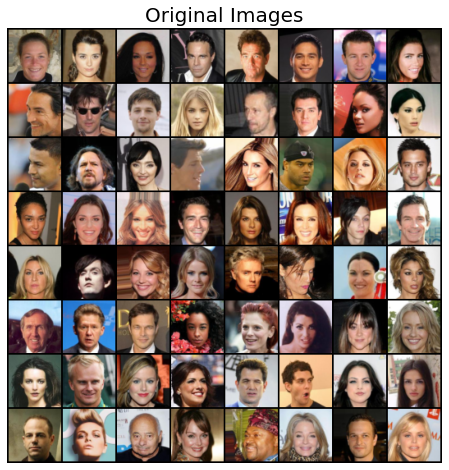

In [5]:
# Plot some of original images
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis('off')
plt.title('Original Images', {'fontsize': 20})
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# Generator model

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias = False),
                              nn.BatchNorm2d(ngf*8),
                              nn.ReLU(True),
                              # (ngf*8,4,4)

                              nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias = False),
                              nn.BatchNorm2d(ngf*4),
                              nn.ReLU(True),
                              # (ngf*4,8,8)

                              nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias = False),
                              nn.BatchNorm2d(ngf*2),
                              nn.ReLU(True),
                              # (ngf*2, 16, 16)

                              nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias = False),
                              nn.BatchNorm2d(ngf),
                              nn.ReLU(True),
                              # (ngf, 32, 32)

                              nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias = False),
                              nn.Tanh()
                              # (nc, 64, 64)
                              )
    
  def forward(self, input):
    return(self.main(input))

In [ ]:
# Moving the model to device
netG = Generator(ngpu).to(device)

In [ ]:
# Discriminator model
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
                              nn.LeakyReLU(0.2, inplace = True),
                              
                              nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias = False),
                              nn.BatchNorm2d(ndf*2),
                              nn.LeakyReLU(0.2, inplace=True),
                              
                              nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias = False),
                              nn.BatchNorm2d(ndf*4),
                              nn.LeakyReLU(0.2, inplace = True),
                              
                              nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias = False),
                              nn.BatchNorm2d(ndf*8),
                              nn.LeakyReLU(0.2, inplace=True),
                              
                              nn.Conv2d(ndf*8, 1, 4, 1, 0, bias = False),
                              nn.Sigmoid())
    
  def forward(self, input):
    return(self.main(input))

In [ ]:
# Moving the model to device
netD = Discriminator(ngpu).to(device)

## Generated Fake Images

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:623: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:623: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


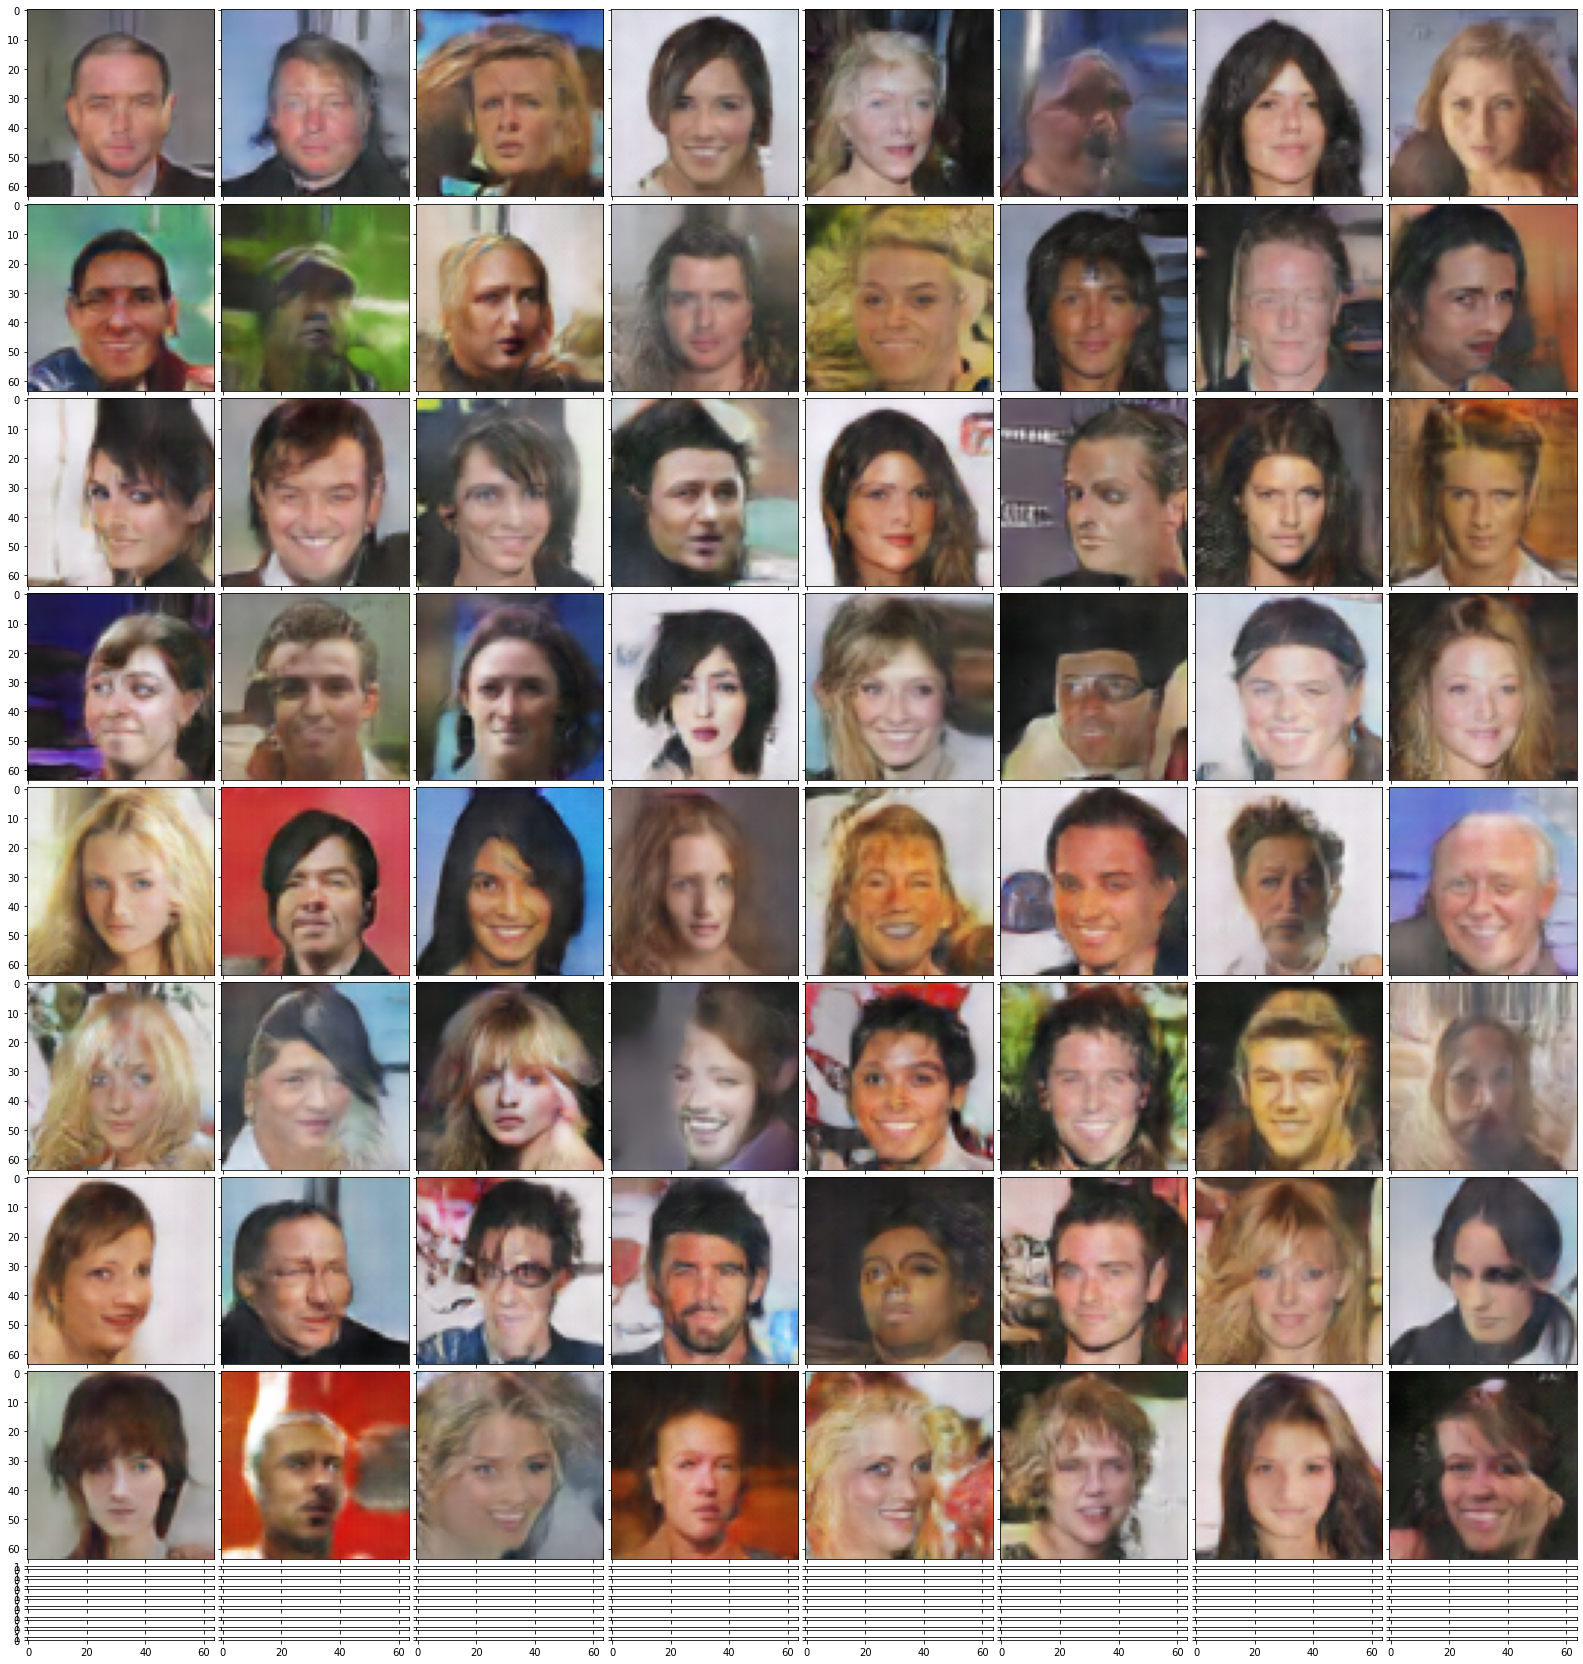

In [ ]:
# Load model parameters
netG = torch.load('./weights/generator.pth')
netD = torch.load('./weights/discriminator.pth')

# Generate random noise
noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Generate a batch of fake image with G
fake = netG(noise)  

# Convert (-1,1) --> (0,1)
fake = (fake + 1)/2

# Plot the generated images
img = [np.transpose(fake[i].cpu().detach().numpy(),(1,2,0)) for i in range(fake.shape[0])]
fig = plt.figure(figsize=(40., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, img):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)